In [4]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [5]:
# Specify visible cuda device
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
from parameters import *
from lib.utils import *
from lib.attacks import *

import numpy as np
import tensorflow as tf

In [7]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

y_train_cat = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test_cat = keras.utils.to_categorical(y_test, NUM_LABELS)

---

In [8]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [9]:
def fn_mnist_cnn_hinge(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[3, 3],
        activation=tf.nn.relu)

    # Convolutional Layer and pooling #2
    conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters=64,
        kernel_size=[3, 3],
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dropout #1
    drop1 = tf.layers.dropout(
        inputs=pool1, rate=0.25, training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    # Dense Layer
    drop1_flat = tf.reshape(drop1, [-1, 12 * 12 * 64])
    dense = tf.layers.dense(inputs=drop1_flat, units=128, activation=tf.nn.relu)
    drop2 = tf.layers.dropout(
        inputs=dense, rate=0.5, training=(mode == tf.estimator.ModeKeys.TRAIN))

    # Logits Layer
    logits = tf.layers.dense(inputs=drop2, units=10, name="logits")

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
 
    # Structured hinge loss max{0, 1 - (y_label - y_max)}
    # Not so elegant way to index tensor with another tensor
    indices = tf.range(tf.shape(logits)[0])
    gather_ind = tf.stack([indices, labels], axis=1)
    y_label = tf.gather_nd(logits, gather_ind)
    # Get 2 largest outputs
    y_2max = tf.nn.top_k(logits, 2)[0]
    # Find y_max = max(z[i != y])
    i_max = tf.to_int32(tf.argmax(logits, axis=1))
    y_max = tf.where(tf.equal(labels, i_max), y_2max[:, 1],
                     y_2max[:, 0])
    loss = tf.reduce_sum(tf.maximum(0., 100000. - y_label + y_max))
    
    # Calculate batch accuracy
    tmp = tf.cast(tf.equal(i_max, labels), dtype=tf.float32)
    accuracy = tf.reduce_mean(tmp, name="accuracy")
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [10]:
def fn_mnist_cnn_margin(features, labels, mode):
    """Model function for CNN."""
    
    lamda = 1.
    
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[3, 3],
        activation=tf.nn.relu)

    # Convolutional Layer and pooling #2
    conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters=64,
        kernel_size=[3, 3],
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dropout #1
    drop1 = tf.layers.dropout(
        inputs=pool1, rate=0.25, training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    # Dense Layer
    drop1_flat = tf.reshape(drop1, [-1, 12 * 12 * 64])
    dense = tf.layers.dense(inputs=drop1_flat, units=128, activation=tf.nn.relu)
    drop2 = tf.layers.dropout(
        inputs=dense, rate=0.5, training=(mode == tf.estimator.ModeKeys.TRAIN))

    # Logits Layer
    logits = tf.layers.dense(inputs=drop2, units=10, name="logits")

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
 
    # Structured hinge loss max{0, 1 - (y_label - y_max)}
    # Not so elegant way to index tensor with another tensor
    indices = tf.range(tf.shape(logits)[0])
    gather_ind = tf.stack([indices, labels], axis=1)
    y_label = tf.gather_nd(logits, gather_ind)
    # Get 2 largest outputs
    y_2max = tf.nn.top_k(logits, 2)[0]
    # Find y_max = max(z[i != y])
    i_max = tf.to_int32(tf.argmax(logits, axis=1))
    y_max = tf.where(tf.equal(labels, i_max), y_2max[:, 1],
                     y_2max[:, 0])
    loss = tf.reduce_sum(tf.maximum(0., 1. - y_label + y_max))
    
    # Add penalty term
    grad = tf.gradients(y_label, input_layer, name='grad')
    grad_norm = tf.norm(tf.reshape(grad, shape=[-1, 28 * 28]), 
                        ord='euclidean', axis=-1)
    penalty = tf.reduce_sum(tf.square(grad_norm) / y_label, name='penalty')
    loss += lamda * penalty
    
    # Calculate batch accuracy
    tmp = tf.cast(tf.equal(i_max, labels), dtype=tf.float32)
    accuracy = tf.reduce_mean(tmp, name="accuracy")
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [33]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=fn_mnist_cnn_margin, model_dir='./tmp/mnist_cnn_margin_C1_L1/')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './tmp/mnist_cnn_margin_C1_L1/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2d401e99b0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [34]:
#tensors_to_log = {"probabilities": "softmax_tensor"}
#tensors_to_log = {"gather_ind": "gather_ind", "y_l": "y_l"}
tensors_to_log = {"accuracy": "accuracy",
                  "penalty": "penalty"}
#tensors_to_log = {}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=100)

In [35]:
def get_weights(estimator):
    """
    Extract weights from TF Estimator. Only works with a simple CNN/DNN.
    """

    weights = []
    weight = []
    layer_names = estimator.get_variable_names()
    for layer_name in layer_names:
        if layer_name.endswith("kernel"):
            weight.insert(0, estimator.get_variable_value(layer_name))
            weights.append(weight)
            weight = []
        elif layer_name.endswith("bias"):
            weight.append(estimator.get_variable_value(layer_name))
            
    return weights


def load_weights(model, weights):
    """
    Set weights in Keras model with a list of weights.
    """
    
    i = 0
    for layer in model.layers:
        # Check if layer has trainable weights
        if not layer.trainable_weights:
            continue
        # Set weight
        layer.set_weights(weights[i])
        i += 1
        
    assert i == len(weights), "Number of layers mismatch."

---

In [36]:
weight_path = './tmp/mnist_cnn_margin_C1_L1/model'
n_epochs = 50

max_test_acc = 0
save_i = 0
train_out = {'accuracy': [], 'loss':[]}
test_out = {'accuracy': [], 'loss':[]}
model = build_cnn_mnist()

for i in range(n_epochs):
    
    if i % 2 is 0:
        try:
            train_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={"x": x_train},
                y=y_train,
                batch_size=128,
                num_epochs=2,
                shuffle=True)       

            mnist_classifier.train(
                input_fn=train_input_fn,
                hooks=[logging_hook])

            eval_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={"x": x_train},
                y=y_train,
                num_epochs=1,
                shuffle=False)
            eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
            train_out['accuracy'].append(eval_results['accuracy'])
            train_out['loss'].append(eval_results['loss'])

            eval_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={"x": x_test},
                y=y_test,
                num_epochs=1,
                shuffle=False)
            eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
            test_acc = eval_results['accuracy']
            test_out['accuracy'].append(test_acc)
            test_out['loss'].append(eval_results['loss'])

            if test_acc > max_test_acc:
                max_test_acc = test_acc
                save_i = i
                weights = get_weights(mnist_classifier)
                load_weights(model, weights)
                model.save_weights(weight_path + '.h5')
                stop_counter = 0
            else:
                stop_counter += 1

            if stop_counter == 5:
                break
                
        except:
            print('--------- NaN encountered - epoch {} ---------'.format(i))
            pass
            
pickle.dump(train_out, open(weight_path + '_train.p', 'wb'))
pickle.dump(test_out, open(weight_path + '_test.p', 'wb'))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./tmp/mnist_cnn_margin_C1_L1/model.ckpt.
INFO:tensorflow:accuracy = 0.0859375, penalty = 62.429325
INFO:tensorflow:loss = 210.32149, step = 1
INFO:tensorflow:global_step/sec: 72.1162
INFO:tensorflow:accuracy = 0.4921875, penalty = 11.861118 (1.389 sec)
INFO:tensorflow:loss = 159.93723, step = 101 (1.389 sec)
INFO:tensorflow:global_step/sec: 77.944
INFO:tensorflow:accuracy = 0.359375, penalty = 14.656721 (1.285 sec)
INFO:tensorflow:loss = 206.11952, step = 201 (1.286 sec)
INFO:tensorflow:global_step/sec: 77.6639
INFO:tensorflow:accuracy = 0.3359375, penalty = 18.216902 (1.287 sec)
INFO:tensorflow:loss = 214.31413, step = 301 (1.287 sec)
INFO:tensorflow:global_step/sec: 77.3311
INFO:tensorflow:accuracy = 0.625, penalty = -418.96487 (1.292 sec)
INFO:tensorflow:loss = -312.28857, step = 401 (1.292 sec)
INFO:tensorflow:global_step/sec: 77.8068
INFO:tensorflow:accuracy = 0.390625, penalty = 25.583263 (1

INFO:tensorflow:accuracy = 0.8359375, penalty = 17.24964 (1.268 sec)
INFO:tensorflow:loss = 61.905205, step = 3015 (1.268 sec)
INFO:tensorflow:global_step/sec: 77.7671
INFO:tensorflow:accuracy = 0.828125, penalty = 16.531986 (1.286 sec)
INFO:tensorflow:loss = 64.24631, step = 3115 (1.286 sec)
INFO:tensorflow:global_step/sec: 79.1603
INFO:tensorflow:accuracy = 0.8046875, penalty = 17.473932 (1.261 sec)
INFO:tensorflow:loss = 83.074265, step = 3215 (1.261 sec)
INFO:tensorflow:global_step/sec: 78.1626
INFO:tensorflow:accuracy = 0.875, penalty = 17.742275 (1.281 sec)
INFO:tensorflow:loss = 65.499794, step = 3315 (1.281 sec)
INFO:tensorflow:global_step/sec: 79.1292
INFO:tensorflow:accuracy = 0.828125, penalty = 15.9965725 (1.264 sec)
INFO:tensorflow:loss = 64.711525, step = 3415 (1.264 sec)
INFO:tensorflow:global_step/sec: 79.6693
INFO:tensorflow:accuracy = 0.9453125, penalty = 16.209291 (1.254 sec)
INFO:tensorflow:loss = 49.387245, step = 3515 (1.254 sec)
INFO:tensorflow:global_step/sec: 7

INFO:tensorflow:Saving dict for global step 5629: accuracy = 0.947, global_step = 5629, loss = 25.692705
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1/model.ckpt-5629
INFO:tensorflow:Saving checkpoints for 5630 into ./tmp/mnist_cnn_margin_C1_L1/model.ckpt.
INFO:tensorflow:accuracy = 0.84375, penalty = 11.779324
INFO:tensorflow:loss = 67.25572, step = 5630
INFO:tensorflow:global_step/sec: 72.7436
INFO:tensorflow:accuracy = 0.859375, penalty = 13.791378 (1.377 sec)
INFO:tensorflow:loss = 56.080116, step = 5730 (1.376 sec)
INFO:tensorflow:global_step/sec: 77.3875
INFO:tensorflow:accuracy = 0.859375, penalty = 14.196249 (1.292 sec)
INFO:tensorflow:loss = 53.797836, step = 5830 (1.293 sec)
INFO:tensorflow:global_step/sec: 77.755
INFO:tensorflow:accuracy = 0.5859375, penalty = 27.833742 (1.286 sec)
INFO:tensorflow:loss = 148.12994, step = 5930 (1.286 sec)
INFO:tensorflow:global_step/sec: 77.2411
INFO:tensorflow:accuracy = 0

INFO:tensorflow:global_step/sec: 78.0891
INFO:tensorflow:accuracy = 0.8828125, penalty = 15.604078 (1.281 sec)
INFO:tensorflow:loss = 56.78402, step = 8307 (1.281 sec)
INFO:tensorflow:global_step/sec: 78.3127
INFO:tensorflow:accuracy = 0.875, penalty = 14.028819 (1.279 sec)
INFO:tensorflow:loss = 56.617466, step = 8407 (1.279 sec)
INFO:tensorflow:Saving checkpoints for 8444 into ./tmp/mnist_cnn_margin_C1_L1/model.ckpt.
INFO:tensorflow:Loss for final step: 26.860332.
INFO:tensorflow:Starting evaluation at 2018-04-05-07:05:24
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1/model.ckpt-8444
INFO:tensorflow:Finished evaluation at 2018-04-05-07:05:27
INFO:tensorflow:Saving dict for global step 8444: accuracy = 0.95526665, global_step = 8444, loss = 22.588839
INFO:tensorflow:Starting evaluation at 2018-04-05-07:05:27
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1/model.ckpt-8444
INFO:tensorflow:Finished evaluation at 2018-04-05-07:05:28
INFO:tens

INFO:tensorflow:loss = 87.07275, step = 9886 (1.249 sec)
INFO:tensorflow:global_step/sec: 79.033
INFO:tensorflow:accuracy = 0.7734375, penalty = 13.171916 (1.265 sec)
INFO:tensorflow:loss = 80.07702, step = 9986 (1.265 sec)
INFO:tensorflow:global_step/sec: 78.7703
INFO:tensorflow:accuracy = 0.7421875, penalty = 13.459932 (1.270 sec)
INFO:tensorflow:loss = 87.100365, step = 10086 (1.270 sec)
INFO:tensorflow:global_step/sec: 79.0952
INFO:tensorflow:accuracy = 0.796875, penalty = 11.616753 (1.263 sec)
INFO:tensorflow:loss = 73.465836, step = 10186 (1.263 sec)
INFO:tensorflow:global_step/sec: 79.3204
INFO:tensorflow:accuracy = 0.75, penalty = 10.843011 (1.261 sec)
INFO:tensorflow:loss = 87.26722, step = 10286 (1.261 sec)
INFO:tensorflow:Saving checkpoints for 10323 into ./tmp/mnist_cnn_margin_C1_L1/model.ckpt.
INFO:tensorflow:Loss for final step: 40.21149.
INFO:tensorflow:Starting evaluation at 2018-04-05-07:06:23
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1/model

INFO:tensorflow:Saving dict for global step 11267: accuracy = 0.94663334, global_step = 11267, loss = 24.522152
INFO:tensorflow:Starting evaluation at 2018-04-05-07:07:12
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1/model.ckpt-11267
INFO:tensorflow:Finished evaluation at 2018-04-05-07:07:13
INFO:tensorflow:Saving dict for global step 11267: accuracy = 0.9489, global_step = 11267, loss = 23.441643
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1/model.ckpt-11267
INFO:tensorflow:Saving checkpoints for 11268 into ./tmp/mnist_cnn_margin_C1_L1/model.ckpt.
INFO:tensorflow:accuracy = 0.75, penalty = 8.22784
INFO:tensorflow:loss = 83.60748, step = 11268
INFO:tensorflow:global_step/sec: 74.1913
INFO:tensorflow:accuracy = 0.7578125, penalty = 10.70693 (1.351 sec)
INFO:tensorflow:loss = 80.90545, step = 11368 (1.351 sec)
ERROR:tensorflow:Model diverged with loss = NaN.
--------- NaN encountered - epoch 46 

In [42]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train},
    y=y_train,
    batch_size=128,
    num_epochs=5,
    shuffle=True)

mnist_classifier.train(
    input_fn=train_input_fn,
    hooks=[logging_hook])

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin/model.ckpt-28127
INFO:tensorflow:Saving checkpoints for 28128 into ./tmp/mnist_cnn_margin/model.ckpt.
INFO:tensorflow:accuracy = 0.90625, penalty = 5.5833273
INFO:tensorflow:loss = 42.413994, step = 28128
INFO:tensorflow:global_step/sec: 70.268
INFO:tensorflow:accuracy = 0.8984375, penalty = 5.44296 (1.426 sec)
INFO:tensorflow:loss = 38.43854, step = 28228 (1.426 sec)
INFO:tensorflow:global_step/sec: 78.4443
INFO:tensorflow:accuracy = 0.9375, penalty = 6.6082935 (1.274 sec)
INFO:tensorflow:loss = 22.995775, step = 28328 (1.273 sec)
INFO:tensorflow:global_step/sec: 77.2343
INFO:tensorflow:accuracy = 0.96875, penalty = 4.988967 (1.296 sec)
INFO:tensorflow:loss = 19.176147, step = 28428 (1.296 sec)
INFO:tensorflow:global_step/sec: 77.585
INFO:tensorflow:accuracy = 0.96875, penalty = 6.1280947 (1.288 sec)
INFO:tensorflow:loss = 18.4337, step = 28528 (1.288 sec)
INFO:tensorflow:globa

NanLossDuringTrainingError: NaN loss during training.

In [19]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train},
    y=y_train,
    num_epochs=1,
    shuffle=False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-04-05-06:28:46
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt-15949
INFO:tensorflow:Finished evaluation at 2018-04-05-06:28:49
INFO:tensorflow:Saving dict for global step 15949: accuracy = 0.98911667, global_step = 15949, loss = 5.1310053
{'accuracy': 0.98911667, 'loss': 5.1310053, 'global_step': 15949}


In [20]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_test},
    y=y_test,
    num_epochs=1,
    shuffle=False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-04-05-06:28:49
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt-15949
INFO:tensorflow:Finished evaluation at 2018-04-05-06:28:49
INFO:tensorflow:Saving dict for global step 15949: accuracy = 0.9857, global_step = 15949, loss = 5.7367687
{'accuracy': 0.9857, 'loss': 5.7367687, 'global_step': 15949}


In [134]:
model = build_cnn_mnist()

In [136]:
weights = get_weights(mnist_classifier)
load_weights(model, weights)
model.evaluate(x_train, y_train_cat)

60000/60000 [==============================] - 7s 111us/step


[0.5261392756144205, 0.9660833333333333]

In [137]:
model.save_weights('./tmp/weights/mnist_cnn_margin.h5')

In [ ]:
# Can we change margin? it doesn't have to be 1

---

In [12]:
model = build_cnn_mnist()

In [12]:
model = build_cnn_mnist()
#model.load_weights('./tmp/weights/mnist_cnn_hinge.h5')
#model.load_weights('./tmp/weights/mnist_cnn_smxe.h5')
model.load_weights('./tmp/mnist_cnn_margin_C1_L1/model.h5')

In [42]:
from lib.OptCarlini import *

In [43]:
opt = OptCarlini(model, target=False, c=1, lr=0.01, init_scl=0.1,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

x_adv = np.zeros_like(x_test)
norm = np.zeros(len(x_test))

for i, (x, y) in enumerate(zip(x_test, y_test_cat)):
    y_pred = predict(model, x)
    if y_pred is not np.argmax(y):
        x_adv[i], norm[i] = opt.optimize(x, y, 
                                         weight_path + '.h5', 
                                         n_step=1000, prog=True)

Step: 0, norm=1.619, loss=2.543, obj=4.162
Step: 50, norm=0.709, loss=2.641, obj=3.350
Step: 100, norm=0.421, loss=2.686, obj=3.107
Step: 150, norm=0.364, loss=2.695, obj=3.059
Step: 200, norm=0.345, loss=2.697, obj=3.043
Step: 250, norm=0.337, loss=2.698, obj=3.035
Step: 300, norm=0.333, loss=2.698, obj=3.030
Step: 350, norm=0.330, loss=2.698, obj=3.027
Step: 400, norm=0.328, loss=2.698, obj=3.025
Step: 450, norm=0.326, loss=2.698, obj=3.024
Step: 500, norm=0.325, loss=2.698, obj=3.023
Step: 550, norm=0.325, loss=2.698, obj=3.022
Step: 600, norm=0.324, loss=2.697, obj=3.021
Step: 650, norm=0.323, loss=2.697, obj=3.021
Step: 700, norm=0.323, loss=2.697, obj=3.020
Step: 750, norm=0.323, loss=2.697, obj=3.020
Step: 800, norm=0.323, loss=2.697, obj=3.020
Step: 850, norm=0.322, loss=2.697, obj=3.019
Step: 900, norm=0.322, loss=2.697, obj=3.019
Step: 950, norm=0.322, loss=2.697, obj=3.019
Step: 0, norm=1.696, loss=1.780, obj=3.476
Step: 50, norm=0.978, loss=1.532, obj=2.510
Step: 100, norm=

KeyboardInterrupt: 

In [14]:
opt = OptCarlini(model, target=False, c=1, lr=0.01, init_scl=0.1,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

x_adv = np.zeros_like(x_test)
norm = np.zeros(len(x_test))

for i, (x, y) in enumerate(zip(x_test, y_test_cat)):
    y_pred = predict(model, x)
    if y_pred is not np.argmax(y):
        x_adv[i], norm[i] = opt.optimize(x, y, 
                                         './tmp/mnist_cnn_smxe.h5', 
                                         n_step=1000, prog=True)

Step: 0, norm=13.470, loss=0.000, obj=13.470
Step: 50, norm=8.580, loss=0.000, obj=8.580
Step: 100, norm=5.743, loss=0.013, obj=5.756
Step: 150, norm=4.380, loss=0.000, obj=4.380
Step: 200, norm=3.581, loss=0.000, obj=3.581
Step: 250, norm=3.116, loss=0.000, obj=3.116
Step: 300, norm=2.789, loss=0.000, obj=2.789
Step: 350, norm=2.601, loss=0.000, obj=2.601
Step: 400, norm=2.458, loss=0.000, obj=2.458
Step: 450, norm=2.356, loss=0.000, obj=2.356
Step: 500, norm=2.277, loss=0.000, obj=2.277
Step: 550, norm=2.215, loss=0.000, obj=2.215
Step: 600, norm=2.167, loss=0.000, obj=2.167
Step: 650, norm=2.123, loss=0.000, obj=2.123
Step: 700, norm=2.082, loss=0.000, obj=2.082
Step: 750, norm=2.070, loss=0.000, obj=2.070
Step: 800, norm=2.048, loss=0.000, obj=2.048
Step: 850, norm=2.022, loss=0.000, obj=2.022
Step: 900, norm=1.998, loss=0.000, obj=1.998
Step: 950, norm=1.991, loss=0.000, obj=1.991
Step: 0, norm=13.357, loss=0.000, obj=13.357
Step: 50, norm=8.494, loss=0.000, obj=8.494
Step: 100, n

KeyboardInterrupt: 

In [18]:
opt = OptCarlini(model, target=False, c=1, lr=0.01, init_scl=0.1,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

x_adv = np.zeros_like(x_test)
norm = np.zeros(len(x_test))

for i, (x, y) in enumerate(zip(x_test, y_test_cat)):
    y_pred = predict(model, x)
    if y_pred is not np.argmax(y):
        x_adv[i], norm[i] = opt.optimize(x, y, 
                                         './tmp/mnist_cnn_smxe.h5', 
                                         n_step=1000, prog=True)

Step: 0, norm=13.448, loss=0.000, obj=13.448
Step: 50, norm=8.389, loss=0.000, obj=8.389
Step: 100, norm=5.837, loss=0.000, obj=5.837
Step: 150, norm=4.483, loss=0.003, obj=4.486
Step: 200, norm=3.761, loss=0.000, obj=3.761
Step: 250, norm=3.256, loss=0.000, obj=3.256
Step: 300, norm=2.922, loss=0.000, obj=2.922
Step: 350, norm=2.702, loss=0.000, obj=2.702
Step: 400, norm=2.547, loss=0.000, obj=2.547
Step: 450, norm=2.442, loss=0.000, obj=2.442
Step: 500, norm=2.349, loss=0.000, obj=2.349
Step: 550, norm=2.266, loss=0.027, obj=2.292
Step: 600, norm=2.220, loss=0.000, obj=2.220
Step: 650, norm=2.178, loss=0.000, obj=2.178
Step: 700, norm=2.142, loss=0.000, obj=2.142
Step: 750, norm=2.109, loss=0.000, obj=2.109
Step: 800, norm=2.085, loss=0.000, obj=2.085
Step: 850, norm=2.074, loss=0.000, obj=2.074
Step: 900, norm=2.058, loss=0.000, obj=2.058
Step: 950, norm=2.039, loss=0.000, obj=2.039
Step: 0, norm=13.334, loss=0.014, obj=13.348
Step: 50, norm=8.460, loss=0.000, obj=8.460
Step: 100, n

KeyboardInterrupt: 

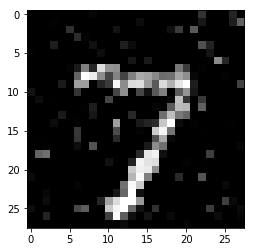

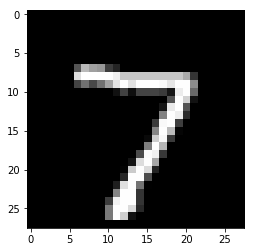

3

In [87]:
i = 0
plt.imshow(x_adv[i].reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
plt.show()
predict(model, x_adv[i])

In [41]:
adv_path = './tmp/adv/mnist_cnn_smxe_ut'

x_adv = pickle.load(open(adv_path + '.p', 'rb'))
norm = pickle.load(open(adv_path + '_norm.p', 'rb'))

print(eval_adv(model, x_adv, y_test_cat[:1000], target=False))
print(np.mean(norm))

1.0
1.7619686784297228


In [11]:
adv_path = './tmp/adv/mnist_cnn_hinge_ut'

x_adv = pickle.load(open(adv_path + '.p', 'rb'))
norm = pickle.load(open(adv_path + '_norm.p', 'rb'))

print(eval_adv(model, x_adv, y_test_cat[:1000], target=False))
print(np.mean(norm))

0.99
1.7483367365896703


In [39]:
adv_path = './tmp/adv/mnist_cnn_hinge_10_ut'

x_adv = pickle.load(open(adv_path + '.p', 'rb'))
norm = pickle.load(open(adv_path + '_norm.p', 'rb'))

print(eval_adv(model, x_adv, y_test_cat[:1000], target=False))
print(np.mean(norm))

1.0
1.9846761872768401


In [9]:
adv_path = './tmp/adv/mnist_cnn_smxe_ut_w'

x_adv = pickle.load(open(adv_path + '.p', 'rb'))
norm = pickle.load(open(adv_path + '_norm.p', 'rb'))

print(eval_adv(model, x_adv, y_test_cat[:1000], target=False))
print(np.mean(norm))

1.0
2.0220260658711195


In [13]:
adv_path = './tmp/adv/mnist_cnn_margin_C1_L1'

x_adv = pickle.load(open(adv_path + '.p', 'rb'))
norm = pickle.load(open(adv_path + '_norm.p', 'rb'))

print(eval_adv(model, x_adv, y_test_cat[:1000], target=False))
print(np.mean(norm))

0.257
0.6817249667933211


In [38]:
model.evaluate(x_test, y_test_cat)

10000/10000 [==============================] - 1s 132us/step


[0.46184693212509154, 0.96]

In [37]:
test_out

{'accuracy': [0.8874,
  0.9267,
  0.9428,
  0.8998,
  0.958,
  0.947,
  0.9274,
  0.9514,
  0.9574,
  0.96,
  0.9482,
  0.9489],
 'loss': [59.199047,
  38.387955,
  30.049332,
  45.49747,
  22.247637,
  25.692705,
  39.69093,
  23.924044,
  21.638086,
  19.400446,
  24.211601,
  23.441643]}